# OpSim -- simulation

## About

This notebook is for testing of the OpSim functionality.
An attempt was made to simplify code, so in most cases we
rely on the precalculated Sun trajectory and the solar
panel power output profile, loaded from files.

In [1]:
# Jupyter magic for autoreload:
%reload_ext autoreload
%autoreload 2

# Standard imports and utility

import numpy as np
import matplotlib.pyplot as plt
import simpy


In [2]:
# Load lusee and OpSim

import  lusee
from    nav        import * # includes luseepy
from    bms.parts  import * # Battery
from    bms.panels import *
from    bms.controller import *
from    bms.battery import *
# ----------------------------------------------------
print(f'''simpy version: {simpy.__version__}''')
print(f'''lusee version: {lusee.__version__}''')


simpy version: 4.0.2
lusee version: 1.2-dev


---

### Read the prefab data for the _Sun trajectory_

Read the data such as prepared with the _prep-sun_ script

In [3]:
# Read the prefab data on sun trajectory
import os
from nav import Sun
print('Current directory:', os.getcwd())

mySun = Sun()

cachefile = '../data/2025-02-04_03-07.npy'
mySun.read_trajectory(cachefile)
print(f'''Number of points read from the file {cachefile}: {mySun.N}''')

sun = mySun.xyz # altaz2xyz(mySun.alt, mySun.az)
hrs = mySun.hrsFromSunrise


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Number of points read from the file ../data/2025-02-04_03-07.npy: 2993


---

### Panel Exposure

Read the "panel exposure" data, such as prepared by the _prep-power_ script. This is essentially
the effective area as defined by the Sun position and geometry of the panels


In [4]:
import os
print('Current directory:', os.getcwd())
power_cachefile = '../data/2025-02-04_03-07_power.npy'
temperature_cachefile = "../reference/lunarTemperature30degDiviner.txt"

# with open(power_cachefile, 'rb') as f: pwr = np.load(f) #print(f'''Number of points read from the file {power_cachefile}: {pwr.size}''')

Panel.verbose = True
Panel.read_profile(power_cachefile)


Current directory: /home/maxim/projects/lusee/opsim/notebooks
Loaded data from file "../data/2025-02-04_03-07_power.npy", number of points: 2993


In [5]:
# Define it here so it's easier to move

temp_file_location = "../reference/lunarTemperature30degDiviner.txt"

#f = open(temp_file_location, 'r')
#lncnt = 0
#for line in f:
#    lncnt+=1
#    print(line.strip())
#print("------------------------\nTotal", lncnt)

---

Optionally, print out the power profile numbers to check if they make sense...

In [ ]:
# To check the numerical values -- can convert to a Python list: a = list(pwr) print(*a, sep = ", ")
# Or, print power values with the MJD timestamps:
print(f'''Will attempt to access {mySun.N} points {Panel.profile}''')
for i in range(0, mySun.N):
    print("%5.3f: %5.3f" % (mySun.mjd[i], Panel.profile[i]))


---

### Read the temperature curve
* Data starts at midnight
* -6hrs to shift to hours from sunrise

### FIXME
* Move the data file to a better location (or copy)


In [6]:
temperature_file_location = "../reference/lunarTemperature30degDiviner.txt"
temp_data = np.loadtxt(temperature_file_location, delimiter=',')

mySun.read_temperature(temperature_file_location)



[ 5.97142587  6.25497185  6.49126017  6.57396107  6.71573406  6.96383679
  7.35371251  7.92080447  8.29295856  8.77853105  9.3030911  10.05626011
 10.99649069 11.92589139 12.85754246 13.68792711 14.32590556 15.04489714
 15.925915   16.39174053 16.60440001 17.02971898 17.3487082  17.50229561
 17.73858392 18.07529477 18.58922185 19.0347941  19.96264768 20.92847616
 21.86012723 22.78165166 23.52764762 23.90570892]
Data array: 34, hours per lunar day: 708.7341666666666, t_inc: 0.25


In [74]:
# Checking data (commented out for now, for brevity):
#_ = plt.plot(temp_data[:,0], temp_data[:,1])
#plt.show()

In [7]:
def tempfit():
    x = temp_data[7:35,0]-5+mySun.sunrise # 60726.14583333333
    y = temp_data[7:35,1]
    return np.interp(mySun.mjd, x, y)

    # Original interpolator (Ben)
    # temp_fit = interp1d(time_hrs,temp,kind='cubic')
    


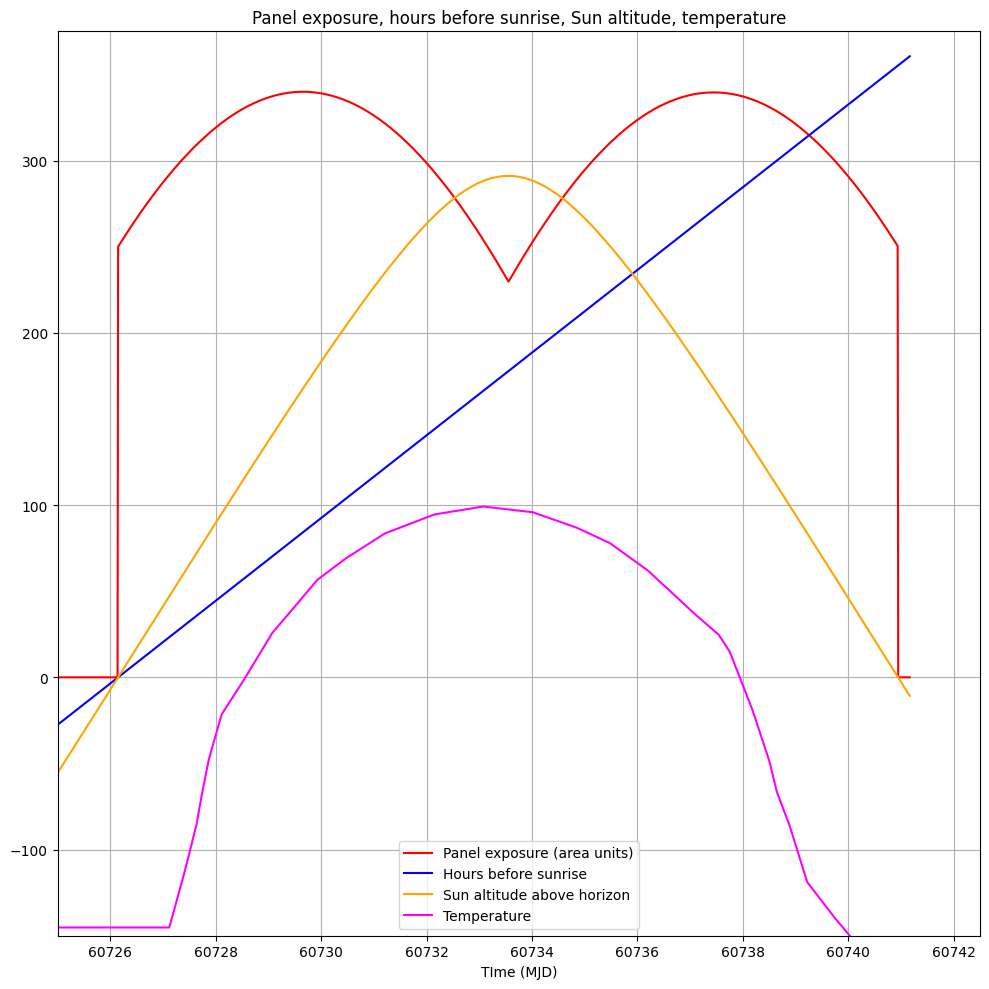

In [8]:
plt.rcParams["figure.figsize"] = [10., 10.]
plt.rcParams["figure.autolayout"] = True

ax=plt.subplot()

ax.plot(mySun.mjd, Panel.profile*250., color="red",    label="Panel exposure (area units)")
ax.set_xlabel('TIme (MJD)')
ax.plot(mySun.mjd, hrs, color="blue",    label="Hours before sunrise")
ax.plot(mySun.mjd, mySun.alt*250, color="orange",  label="Sun altitude above horizon")
ax.plot(mySun.mjd, tempfit()-273., color="Magenta",  label="Temperature")

plt.xlim(60725,60742.5)
plt.ylim(-150,375)
plt.grid(True)
plt.title("Panel exposure, hours before sunrise, Sun altitude, temperature")
plt.legend()

plt.show()


---

Device properties, such as states and power consumption for each state, can be stored in a _YAML_ file and read into the application.


In [9]:
# Read device configuration
import yaml

device_file = '../config/devices.yml'
print(f'''Reading device profiles from the file "{'../config/devices.yml'}"''')
f = open(device_file, 'r')

device_data = yaml.load(f, Loader=yaml.FullLoader)
profiles    = device_data['devices']
print(profiles.keys())



Reading device profiles from the file "../config/devices.yml"
dict_keys(['controller', 'comms'])


Created a Battery with initial charge: 100.0, capacity: 1200.0
List added devices:
controller ON
comms OFF


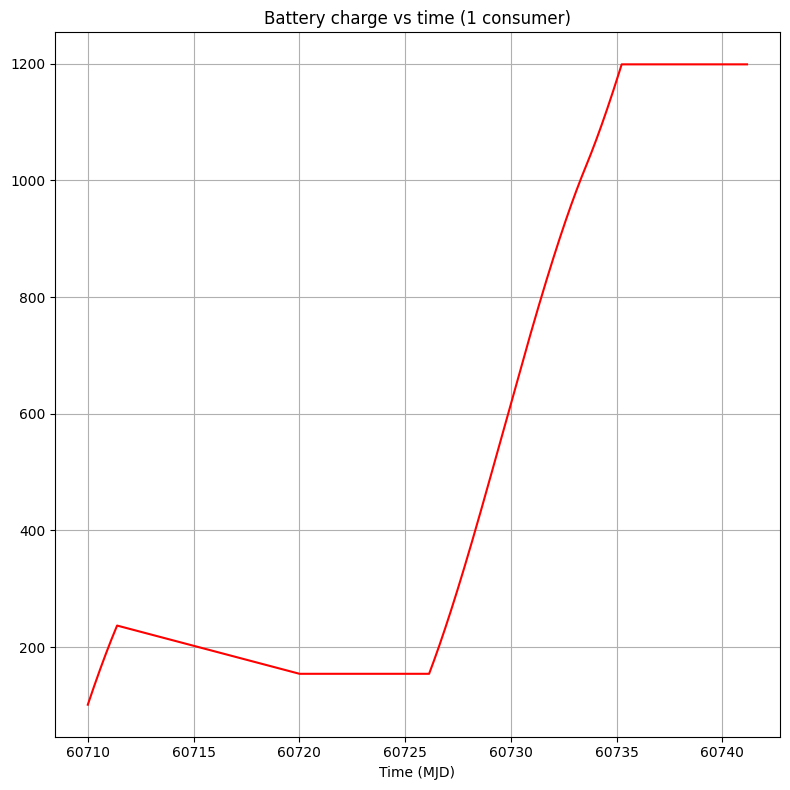

In [10]:
from    bms.battery     import *
from    bms.controller  import *
from    bms.parts       import *

env = simpy.Environment()

initial_charge, capacity = 100., 1200.

battery = Battery(env, initial_charge, capacity)

print(f'''Created a Battery with initial charge: {battery.level}, capacity: {battery.capacity}''')

mon = Monitor(mySun.N) # to define the discrete time axis
ctr = Controller(env, mySun.mjd, battery, mon)
ctr.add_all_panels(mySun)

for device_name in profiles.keys():
    device = Device(device_name, profiles[device_name])
    ctr.add_device(device)

ctr.set_device_state('controller', 'ON')

print('List added devices:')
for added_device in ctr.devices.keys():
        dvc = ctr.devices[added_device]
        print(dvc.name, dvc.state)


ctr.set_condition(mySun.condition)

env.process(ctr.run())
env.run(until=mySun.N)


plt.rcParams["figure.figsize"] = [8., 8.]
plt.rcParams["figure.autolayout"] = True
ax=plt.subplot()
ax.set_xlabel('Time (MJD)')

ax.plot(mySun.mjd, ctr.monitor.battery, color="red",    label="Panel power (a.u.)")

# --- plt.xlim(-100,400)
plt.grid(True)
plt.title("Battery charge vs time (1 consumer)")
plt.show()



